# SigPy for MRI Tutorial Part 3: Building an L1 Wavelet Reconstruction App

In this notebook, we will create an L1 wavelet regularized reconstruction [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App) from scratch. As you will see, [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App)s can be easily created using tools provided by SigPy.

In particular, SigPy provides three supporting classes for building iterative reconstruction [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App)'s: 

- [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop) for linear operator
- [Prox](https://sigpy.readthedocs.io/en/latest/generated/sigpy.prox.Prox.html#sigpy.prox.Prox) for proximal operator
- [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg) for iterative algorithms

This is similar to how BART abstracts iterative reconstructions. By dividing functions into these three classes, many components can be reused, and code can be drastically shortened.

![architecture](https://sigpy.readthedocs.io/en/latest/_images/architecture.png)

## Setup

Let us import relevant packages and load the 8-channel Cartesian brain dataset used in part 2.

In [1]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

In [2]:
ksp = np.load('data/cartesian_ksp.npy')
img_shape = ksp.shape[1:]

The L1 wavelet regularization reconstruction solves the following problem:
$$\min_x \frac{1}{2} \| \underbrace{P F S W^H}_{A} x - y \|_2^2 + \lambda \| x \|_1$$
where $P$ is the sampling operator, $F$ is the Fourier transform operator, $S$ is the sensitivity map operator, $W^H$ is the inverse wavelet transform operator, $x$ is the wavelet coefficients and $y$ is the acquired k-space measurements. We will denote the overall linear operator as $A = P F S W^H$.

The reconstruction image can be generated from $W^H x$.

We will create an L1 wavelet reconstruction App by doing:

- Create [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop)s $P, F, S, W$
- Create Prox of the L1 norm
- Create Alg

## Linop

Linear operators are abstracted in the class [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop). Given a Linop A, and an appropriately shaped input x, we can compute x -> A(x) by:

       >>> y = A(x)

Its adjoint linear operator can be obtained using the `.H` attribute. Linops can be scaled, added, subtracted, stacked and composed.

In the following, we will create the neccessary [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop)s, $F$, $S$, $P$, and $W$.

### $F$ Linop
To start, we will create an [FFT](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.FFT.html#sigpy.linop.FFT) Linop.  It takes the input array shape and application axes as arguments. We will also apply its adjoint, which is the inverse FFT, to the k-space array `ksp` to verify if it's working.

<IPython.core.display.Javascript object>


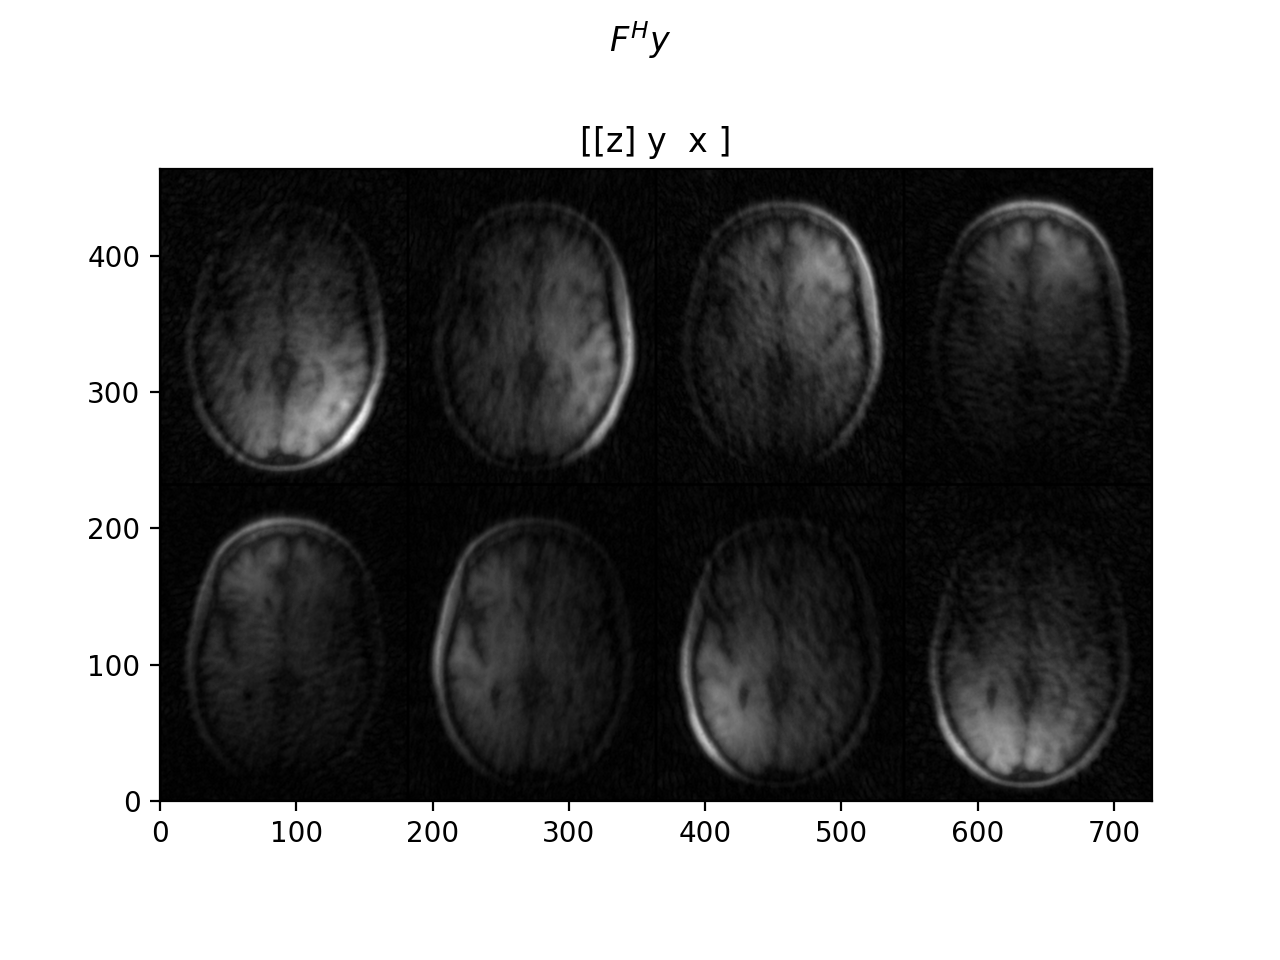

In [3]:
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))

pl.ImagePlot(F.H * ksp, z=0, title=r'$F^H y$')

### $S$ Linop

The next [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop) we will create is the sensitivity maps operator. Similar to part 2 of the tutorial, we will first use the [EspiritCalib](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.EspiritCalib.html#sigpy.mri.app.EspiritCalib) App to estimate the sensitivity maps.

In [4]:
mps = mr.app.EspiritCalib(ksp).run()

EspiritCalib: 100%|██████████| 100/100 [00:01<00:00, 75.96it/s]


Given the sensitivity maps, this operator simply multiplies the input image with the maps. We can use the [Multiply](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Multiply.html#sigpy.linop.Multiply) Linop, which takes the input array shape and the array to be multiplied with as arguments. Let us do that and apply its adjoint on `F.H * y` to verify if it's working.

<IPython.core.display.Javascript object>


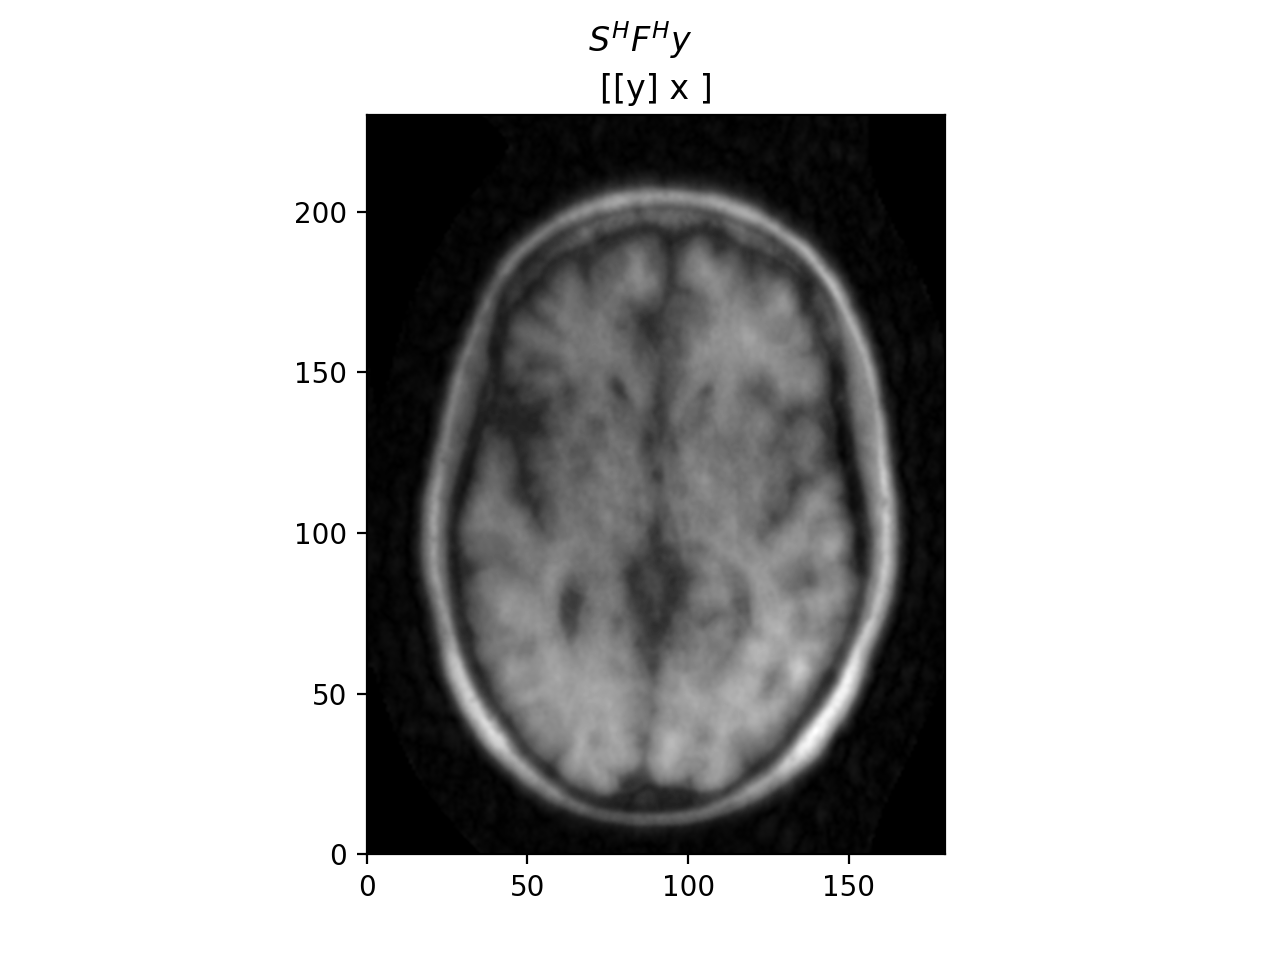

In [5]:
S = sp.linop.Multiply(img_shape, mps)

pl.ImagePlot(S.H * F.H * ksp, title=r'$S^H F^H y$')

### $P$ Linop

The sampling operator is also similar to the sensitivity maps operator: Given the sampling mask, this is another multiplication operator. We will estimate the sampling mask from the non-zero entries of the k-space arrays.

<IPython.core.display.Javascript object>


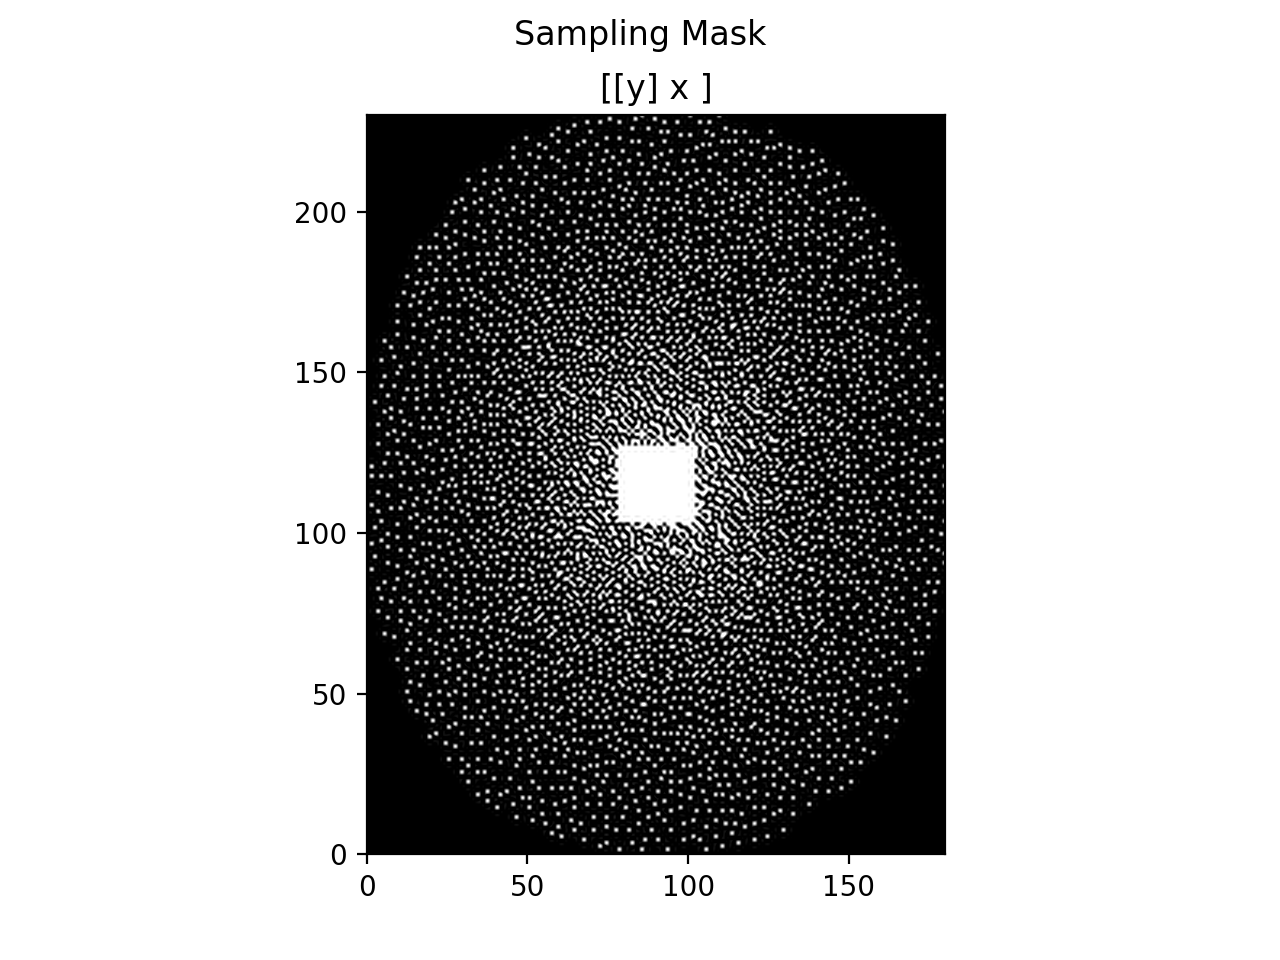

In [6]:
mask = np.sum(abs(ksp), axis=0) > 0
pl.ImagePlot(mask, title='Sampling Mask')

P = sp.linop.Multiply(ksp.shape, mask)

### $W$ Linop

We will create a wavelet transform operator using the [Wavelet](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Wavelet.html#sigpy.linop.Wavelet) Linop. It takes the input array shape as input. By defualt, it uses the Daubechies-4 wavelet transform. Let us apply it to an image to see if the result makes sense.

<IPython.core.display.Javascript object>


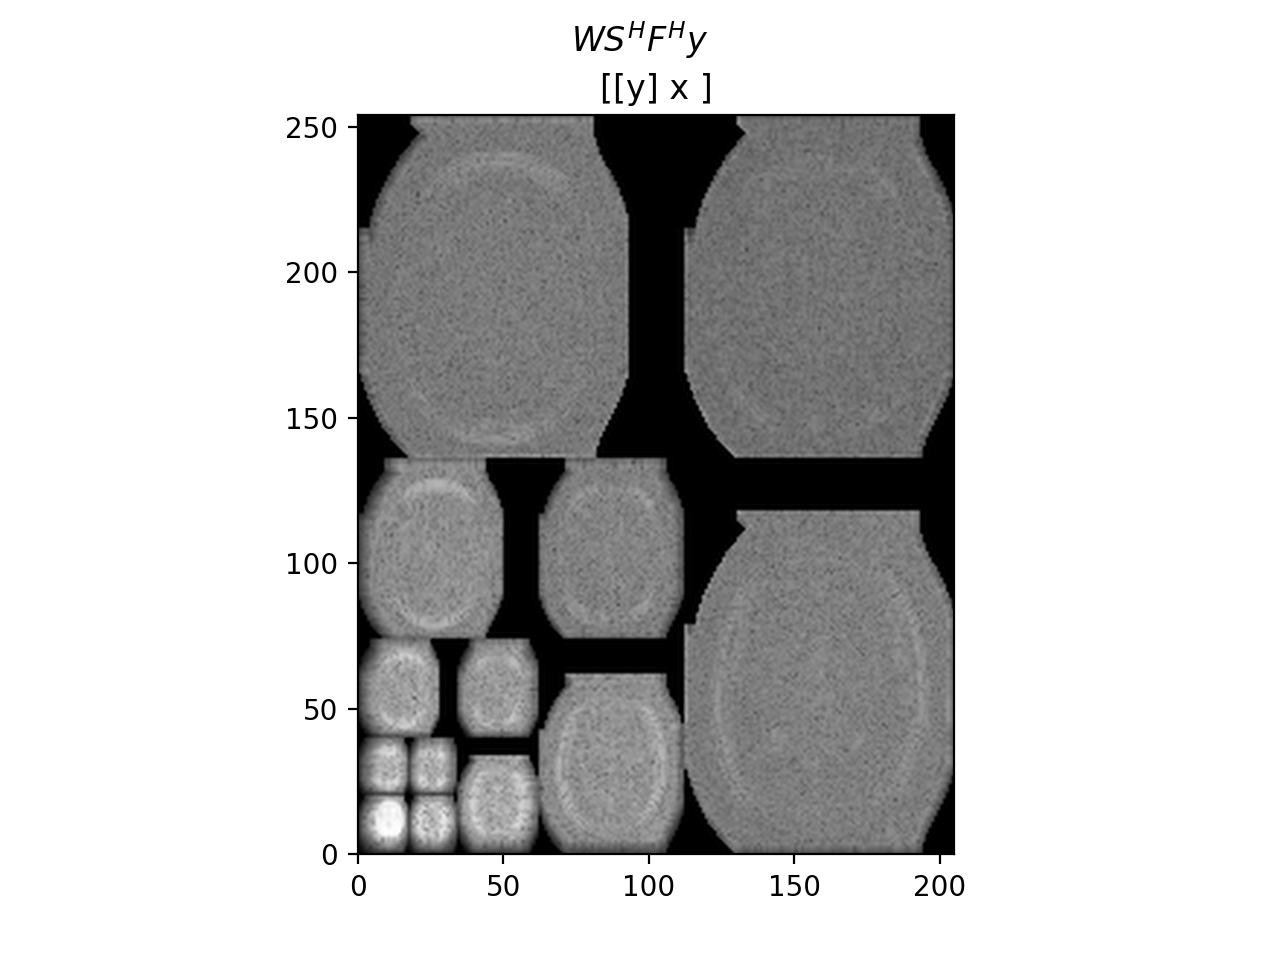

In [7]:
W = sp.linop.Wavelet(img_shape)
wav = W * S.H * F.H * ksp
pl.ImagePlot(wav**0.1, title=r'$W S^H F^H y$')

### $A$ Linop

Finally, we will chain the [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop)s together and form an overall $A$ [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop) for convenience. This can be done simply by multiplying the [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop)s together, which performs composition of linear operators:

In [8]:
A = P * F * S * W.H

# Prox

Proximal operators are abstracted in the class [Prox](https://sigpy.readthedocs.io/en/latest/generated/sigpy.prox.Prox.html#sigpy.prox.Prox). Given a function $g(x)$, a proximal operator is called on a scalar ($\alpha$) and an array $x$ to compute:
$$\text{prox}_{\alpha g} (y) = \text{argmin}_x \frac{1}{2} || x - y ||_2^2 + \alpha g(x)$$

Here, our function $g(x) = \lambda \| x \|_1$ is a scaled L1-norm function. We can use the [L1Reg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.prox.L1Reg.html#sigpy.prox.L1Reg) Prox, which performs a soft-thresholding operation. It takes the input array shape and the regularization parameter $\lambda$ as arguments.

We will define the L1 regularization proximal operator and apply it on the wavelet coefficients.

<IPython.core.display.Javascript object>


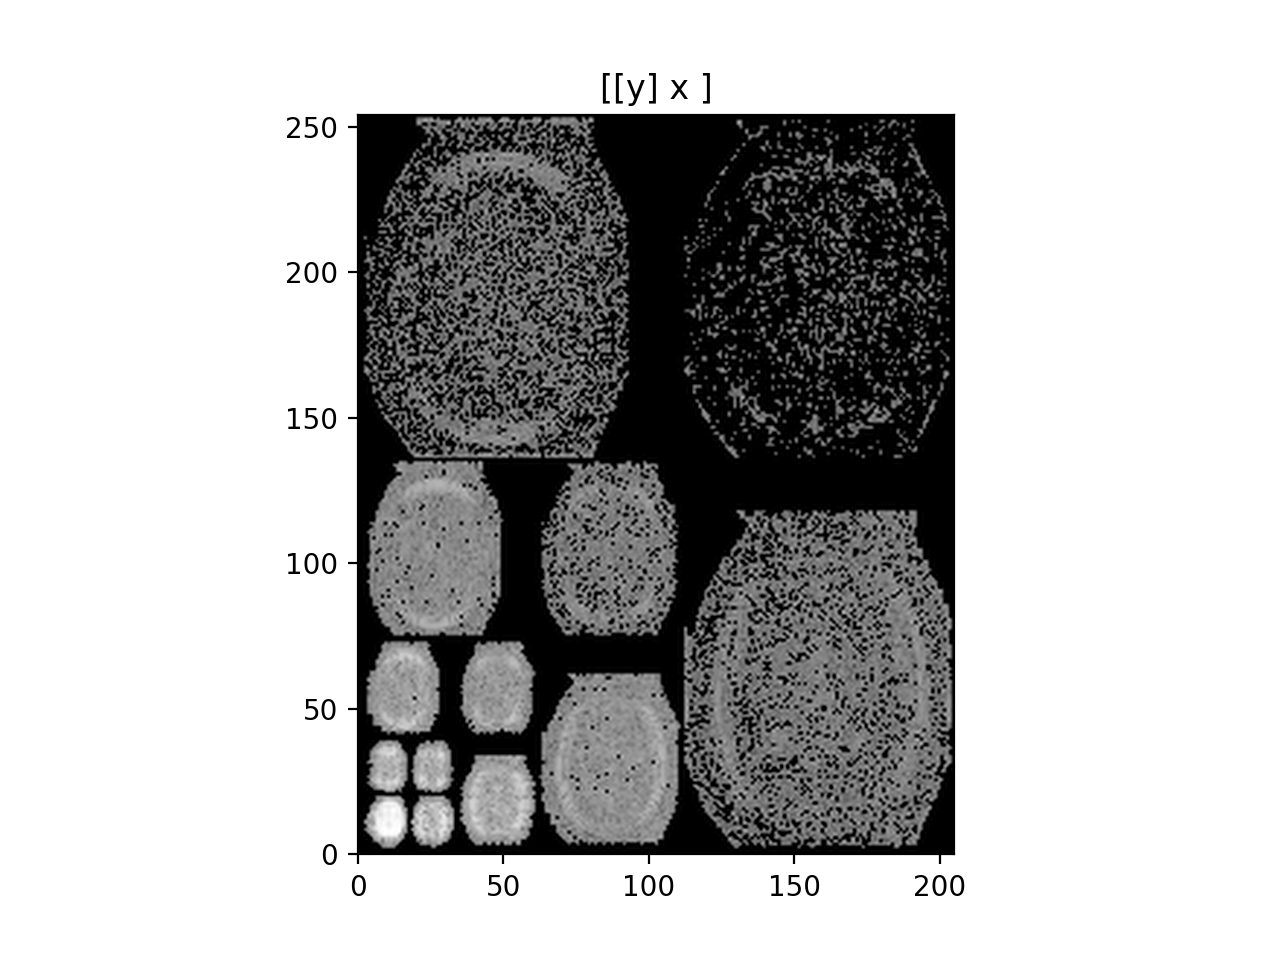

In [9]:
lamda = 0.005
proxg = sp.prox.L1Reg(wav.shape, lamda)
alpha = 1
wav_thresh = proxg(alpha, wav)

pl.ImagePlot(wav_thresh**0.1)

# Alg

[Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg) abstracts iterative algorithms. The standard way of using an [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg), say alg, is as follows:

    >>> while not alg.done():
    >>>     alg.update()

The user is free to run other things in the while loop.

For this tutorial, we will use the [GradientMethod](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.GradientMethod.html#sigpy.alg.GradientMethod) Alg to perform proximal gradient descent. It takes a gradient function, a solution array, and step-size as neccessary inputs. We will also provide a Prox to the optional argument `proxg`.


L1WaveletRecon, Iteration=30

<IPython.core.display.Javascript object>


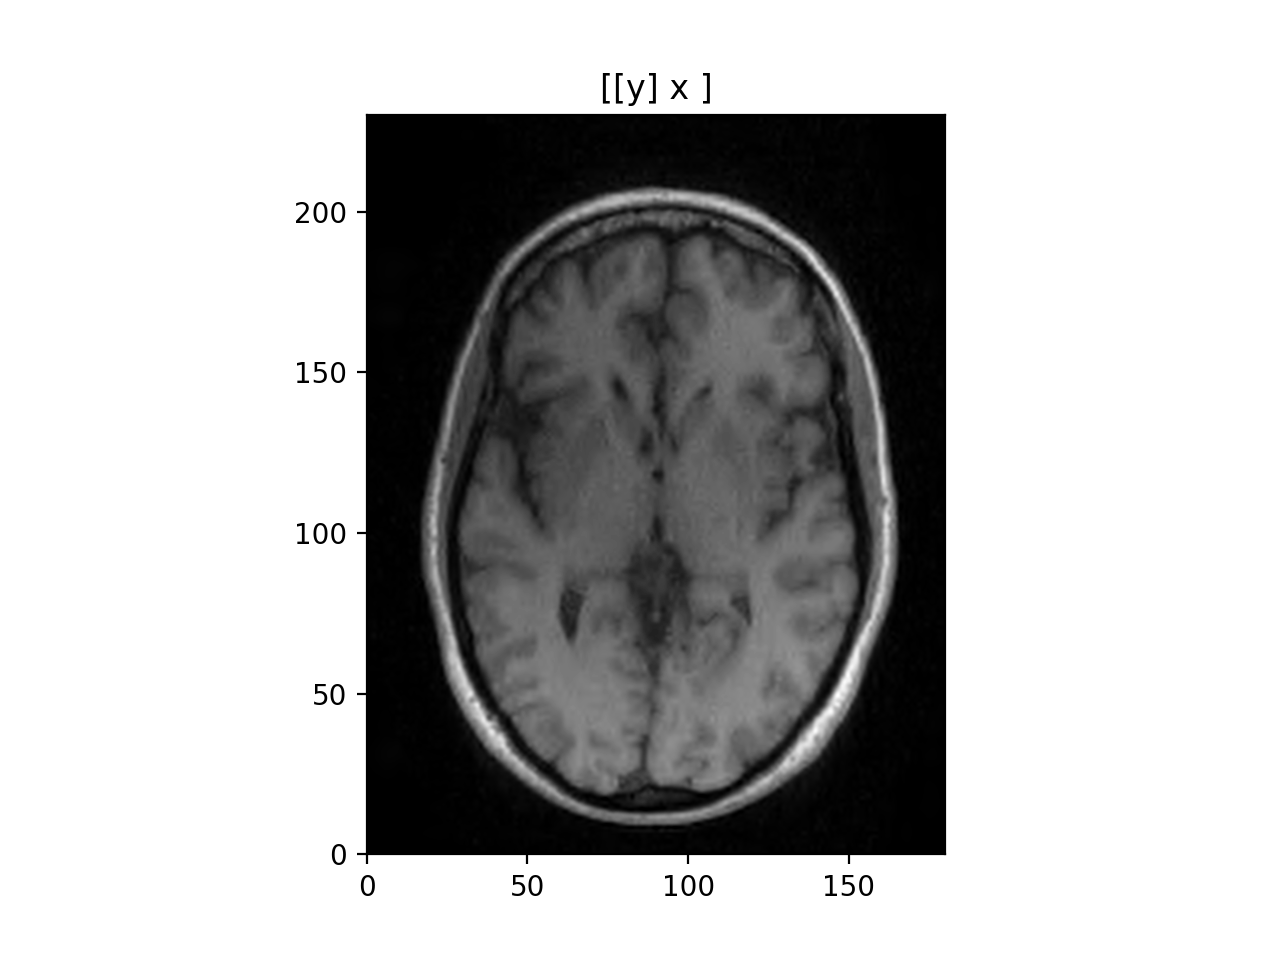

In [10]:
max_iter = 30
alpha = 1

def gradf(x):
    return A.H * (A * x - ksp)

wav_hat = np.zeros(wav.shape, np.complex)
alg = sp.alg.GradientMethod(gradf, wav_hat, alpha, proxg=proxg, max_iter=max_iter)

while not alg.done():
    alg.update()
    print('\rL1WaveletRecon, Iteration={}'.format(alg.iter), end='')

pl.ImagePlot(W.H(wav_hat))

# App

Now that we know how to define the right [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop), [Prox](https://sigpy.readthedocs.io/en/latest/generated/sigpy.prox.Prox.html#sigpy.prox.Prox), and [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg), we can wrap all of them into an [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App).

An [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App) is the final deliverable for each signal reconstruction application. It provides a simple interface to use applications. The standard way to run an [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App), say app, is as follows:

    >>> app.run()

Each [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App) must have a core Alg object. The `run()` function runs the Alg, with additional convenient features, such as a progress bar, which can be toggled with the `show_pbar` option.

We will copy the construction codes from above and form an `L1WaveletRecon` App.

In [11]:
class L1WaveletRecon(sp.app.App):
    def __init__(self, ksp, mask, mps, lamda, max_iter):
        img_shape = mps.shape[1:]
        
        S = sp.linop.Multiply(img_shape, mps)
        F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
        P = sp.linop.Multiply(ksp.shape, mask)
        self.W = sp.linop.Wavelet(img_shape)
        A = P * F * S * self.W.H
        
        proxg = sp.prox.L1Reg(A.ishape, lamda)
        
        self.wav = np.zeros(A.ishape, np.complex)
        alpha = 1
        def gradf(x):
            return A.H * (A * x - ksp)

        alg = sp.alg.GradientMethod(gradf, self.wav, alpha, proxg=proxg, 
                                    max_iter=max_iter)
        super().__init__(alg)
        
    def _output(self):
        return self.W.H(self.wav)

L1WaveletRecon: 100%|██████████| 30/30 [00:02<00:00, 15.17it/s]


<IPython.core.display.Javascript object>


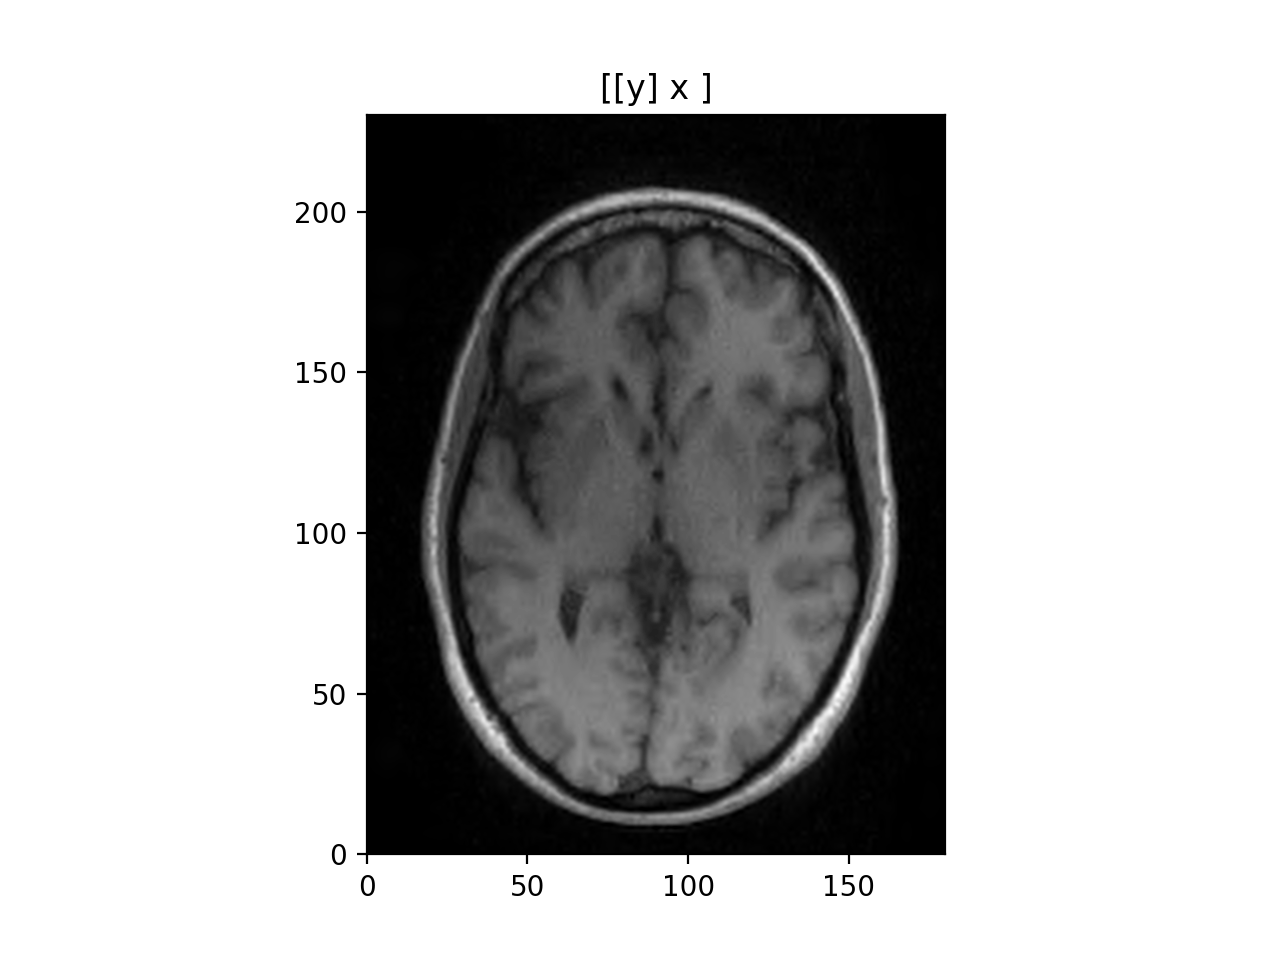

In [12]:
img = L1WaveletRecon(ksp, mask, mps, lamda, max_iter).run()
pl.ImagePlot(img)

Now you know how to build an [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App) from scratch! You can try to extend the App to support GPUs using device contexts introduced in [part 1](01-gridding-reconstruction.ipynb). You can also try to extend the App for non-Cartesian datasets using the [NUFFT](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.NUFFT.html#sigpy.linop.NUFFT) Linop. You can check out [LinearLeastSquares](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.LinearLeastSquares.html#sigpy.app.LinearLeastSquares) too, which can be leveraged to simplify a lot of the code.

We hope you enjoyed going through the SigPy for MRI tutorial. If you have any suggestions on extending SigPy, please let us know on [Github](https://github.com/mikgroup/sigpy/issues).